In [1]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from general_graph_utils import *

Unidirectional, all rates same in one direction and other direction.

Fixed force.

Suppose our system is an enzyme that can convert through three states in a single cycle:

$$E_1 \rightleftharpoons E_2 \rightleftharpoons E_3 \rightleftharpoons E_1$$

Let us label the edge $\ell(i \to j)$ as $k^+_i$, and its reverse $\ell(j \to i)$ as $k^-_i$. The cycle force $\mathcal{A}$ is given as

$$\mathcal{A} = \ln  \prod_{i = 1}^N \dfrac{k^+_i}{k^-_i} \, . $$

We get oscillations when the eigenvalues are complex. It's key to ensure that the initial parameterization yields complex eigenvalues.

Let's set up a graph with labeled edges that represents the set-up described above.

In [76]:
k_1p = math.e**67
k_1m = 1.0
k_2p = 1.0
k_2m = 1.0
k_3p = 1.0
k_3m = 1.0

In [77]:
aff = np.log((k_1p*k_2p*k_3p)/(k_1m*k_2m*k_3m))
aff

67.0

In [78]:
L = np.array([[-k_1p-k_1m, k_2m, k_3m], [k_1m, -k_2p-k_2m, k_3p], [k_1p, k_2p, -k_3p-k_3m]])
L

array([[-1.25236317e+29,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00, -2.00000000e+00,  1.00000000e+00],
       [ 1.25236317e+29,  1.00000000e+00, -2.00000000e+00]])

In [79]:
eigvals, eigvecs = scipy.linalg.eig(L)
eigvals

array([-1.25236317e+29+0.j,  0.00000000e+00+0.j, -3.00000000e+00+0.j])

In [86]:
t = np.around(np.arange(0.0,250.0,step=.01), decimals = 2)

In [91]:
list_result = list(map(lambda i: scipy.linalg.expm(L*i), t))

P_0 = np.array([1,0,0])

new_list = np.zeros((len(t),3))

for i in range(len(t)):
    new_list[i] = ((list_result[i]*P_0)[0])[0]

/Users/sabinahaque/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2585: RuntimeWarning: overflow encountered in reduce
  ret = add.reduce(abs(x), axis=row_axis).max(axis=col_axis)


Text(0, 0.5, 'C_1,1(t)')

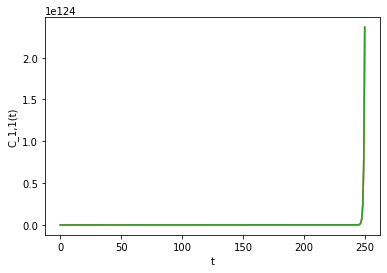

In [92]:
plt.plot(t, new_list)
plt.xlabel('t')
plt.ylabel('C_1,1(t)')
#plt.legend()

More formal workflow

In [57]:
G = nx.DiGraph()
G_size = 3
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,3, weight = k_1m)
G.add_edge(3,1, weight = k_3p)
G.add_edge(2,3, weight = k_2p)
G.add_edge(3,2, weight = k_3m)
G.add_edge(1,2, weight = k_1p)
G.add_edge(2,1, weight = k_2m)


G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 3)
G_ud.add_edge(3, 1)

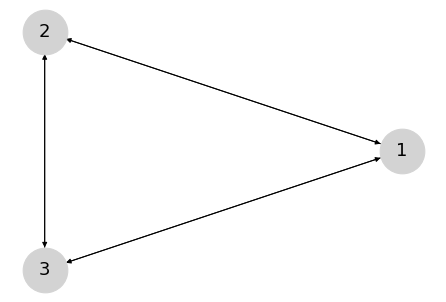

In [58]:
node_labels = {}
node_labels[1] = "1"
node_labels[2] = "2"
node_labels[3] = "3"
nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

Next, we calculate some data structures encoding information about the graph.

In [59]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [60]:
label_dict, label_list = get_labels(G)

In [61]:
label_dict

{(1, 3): 1.0,
 (1, 2): 4.607186634331275e+28,
 (2, 3): 4.607186634331275e+28,
 (2, 1): 1.0,
 (3, 1): 4.607186634331275e+28,
 (3, 2): 1.0}

In [62]:
label_list

array([1.00000000e+00, 4.60718663e+28, 4.60718663e+28, 1.00000000e+00,
       4.60718663e+28, 1.00000000e+00])

Then, we calculate the cycle affinity using the general graphs framework (overkill for the 3-vertex graph, but it works).

In [63]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [64]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[198.]


For fun, we can calculate the steady state distribution using the spectrum of the Laplacian.

In [65]:
L = Laplacian_all(edge_list,label_list,node_list)
pi = steady_state_spectrum(L)

In [66]:
L

array([[-4.60718663e+28,  4.60718663e+28,  1.00000000e+00],
       [ 1.00000000e+00, -4.60718663e+28,  4.60718663e+28],
       [ 4.60718663e+28,  1.00000000e+00, -4.60718663e+28]],
      dtype=float128)

Let's grab the eigenvalues and eigenvectors of the Laplacian matrix.

In [39]:
eigvals, eigvecs = scipy.linalg.eig(L)

In [40]:
eigvals

array([-6.91077995e+28+3.98994067e+28j, -6.91077995e+28-3.98994067e+28j,
       -6.55378477e+12+0.00000000e+00j])

In [41]:
eigvecs

array([[-0.28867513+0.5j, -0.28867513-0.5j, -0.57735027+0.j ],
       [-0.28867513-0.5j, -0.28867513+0.5j, -0.57735027+0.j ],
       [ 0.57735027+0.j ,  0.57735027-0.j , -0.57735027+0.j ]])

Calculate the correlation function $C_{1,1}(t)$

In [42]:
t = np.around(np.arange(100.0,250.0,step=.01), decimals = 2)

In [43]:
list_result = list(map(lambda i: scipy.linalg.expm(L*i), t))

/Users/sabinahaque/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/matfuncs.py:437: RuntimeWarning: overflow encountered in longdouble_scalars
  self._d10_exact = _onenorm(self.A10)**(1/10.)


In [44]:
L

array([[-4.60718663e+28,  4.60718663e+28,  1.00000000e+00],
       [ 1.00000000e+00, -4.60718663e+28,  4.60718663e+28],
       [ 4.60718663e+28,  1.00000000e+00, -4.60718663e+28]],
      dtype=float128)

In [45]:
list_result = list(map(lambda i: scipy.linalg.expm(L*i), t))

P_0 = np.array([1,0,0])

new_list = np.zeros((len(t),3))

for i in range(len(t)):
    new_list[i] = ((list_result[i]*P_0)[0])[0]

/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_8972/908813237.py:8: RuntimeWarning: invalid value encountered in multiply
  new_list[i] = ((list_result[i]*P_0)[0])[0]


In [46]:
new_list[0]

array([inf, inf, inf])

In [47]:
((L*P_0)[:,0])

array([-4.60718663e+28,  1.00000000e+00,  4.60718663e+28], dtype=float128)

Text(0, 0.5, 'C_1,1(t)')

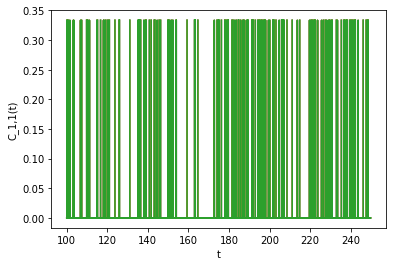

In [50]:
plt.plot(t, new_list)
plt.xlabel('t')
plt.ylabel('C_1,1(t)')
#plt.legend()

What parameter sets give you complex eigenvalues? Need to redefine $G$ s.t. the edge labels become randomly generated.

In [88]:
G = nx.DiGraph()
G_size = 3
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,3)
G.add_edge(3,1)
G.add_edge(2,3)
G.add_edge(3,2)
G.add_edge(1,2)
G.add_edge(2,1)


G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 3)
G_ud.add_edge(3, 1)

In [89]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [90]:
label_dict, label_list = get_labels(G)

In [91]:
label_dict

{(1, 3): 12.8484,
 (1, 2): 112.45916,
 (2, 3): 2.11532,
 (2, 1): 0.03402,
 (3, 1): 0.10834,
 (3, 2): 66.82784}

In [92]:
all_labels = np.zeros((1000,6))
all_eigvals_real = np.zeros((1000,3))
all_eigvals_complex = np.zeros((1000,3))
all_affinities = np.zeros((1000,1))

In [93]:
for i in range(1000):
    label_dict, label_list = get_labels(G)
    all_labels[i] = label_list
    cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f, products_b, cycle_list)
    all_affinities[i] = total_affinities
    L = Laplacian_all(edge_list,label_list,node_list)
    eigvals, eigvecs = scipy.linalg.eig(L)
    eigvals_sorted = np.sort(eigvals)
    all_eigvals_real[i] = eigvals_sorted.real
    all_eigvals_complex[i] = eigvals_sorted.imag

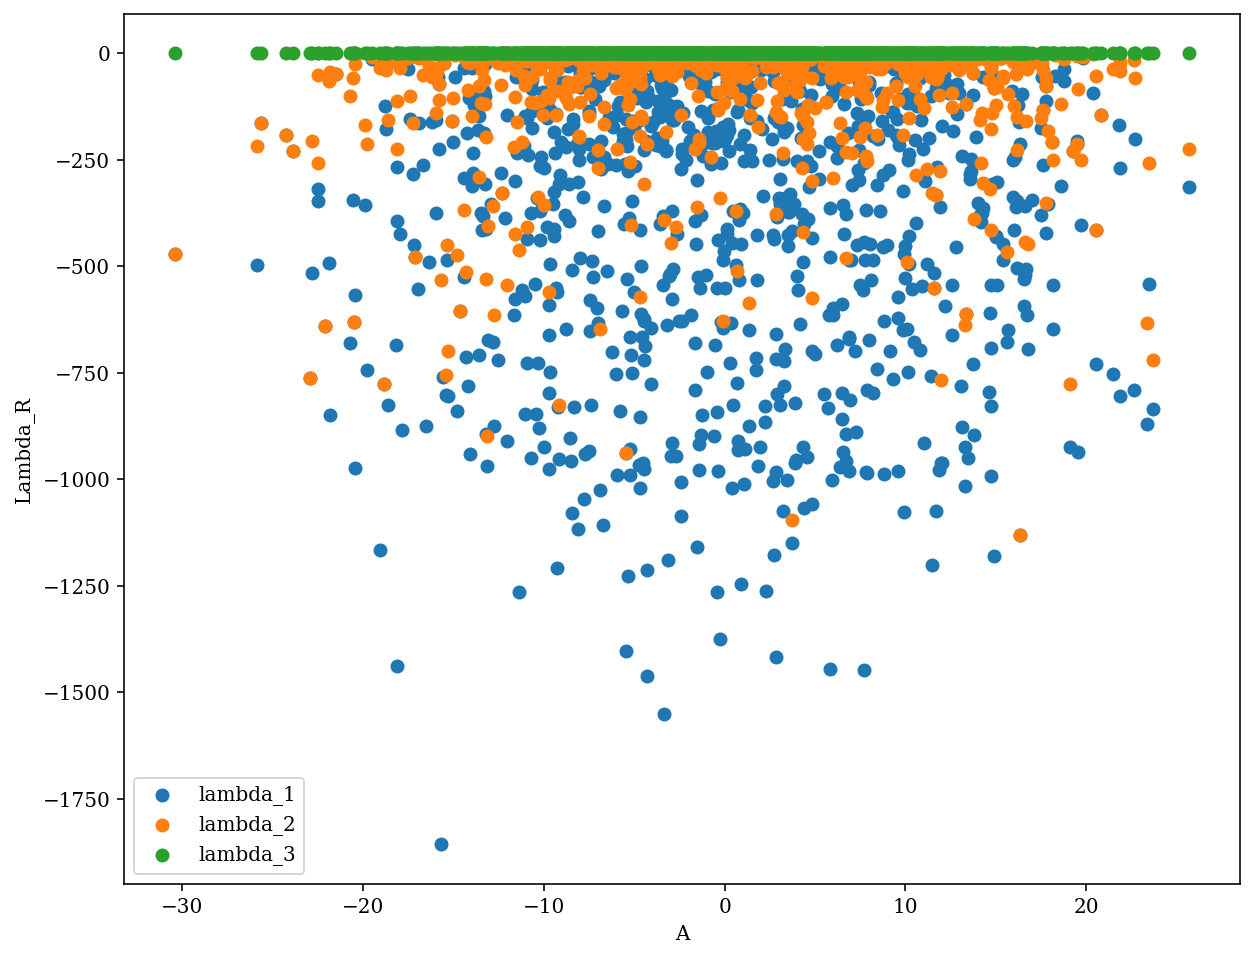

In [94]:
plt.scatter(all_affinities, all_eigvals_real[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_real[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_real[:,2], label='lambda_3')
plt.xlabel('A')
plt.ylabel('Lambda_R')
plt.legend()

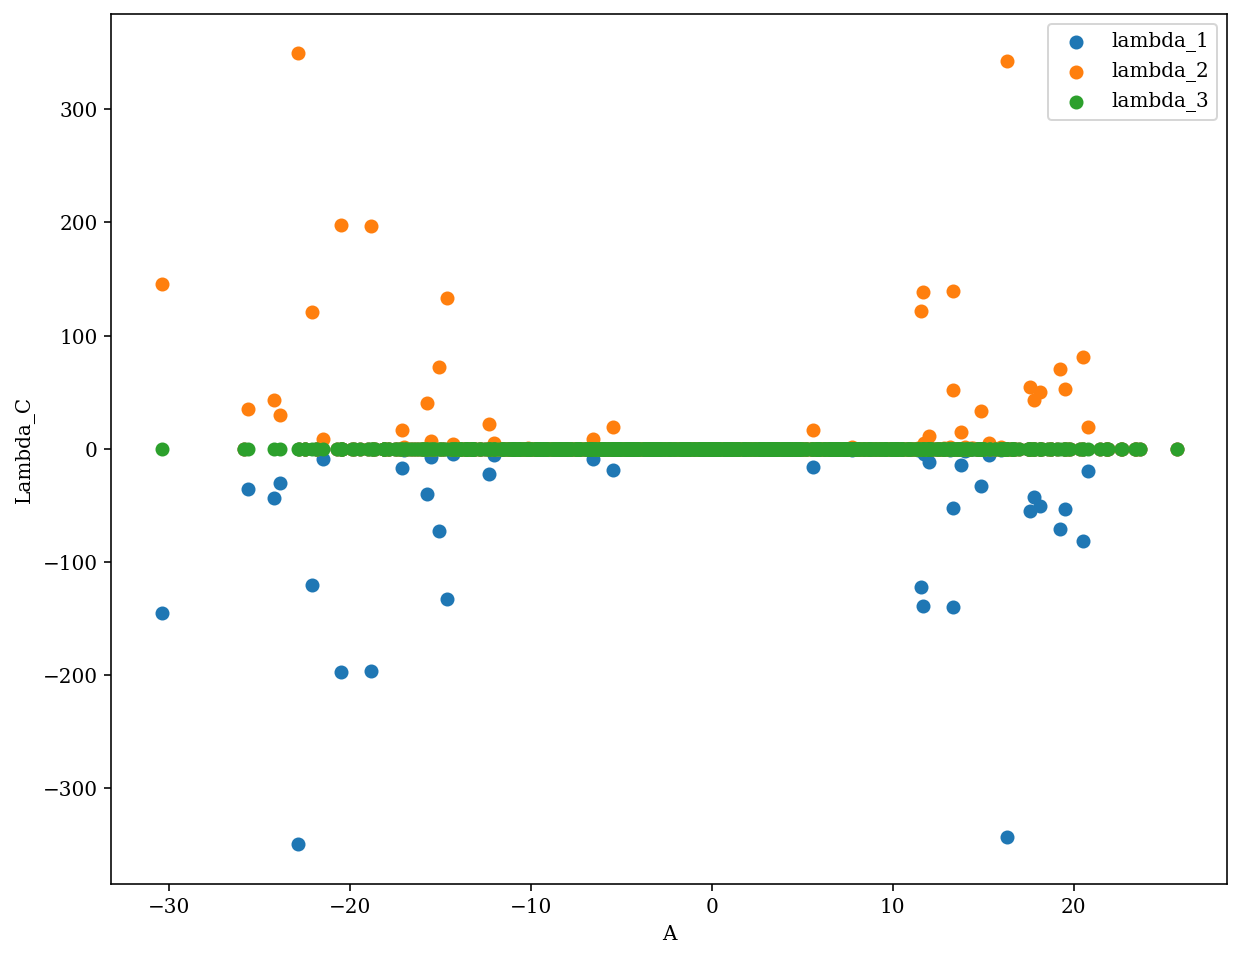

In [95]:
plt.scatter(all_affinities, all_eigvals_complex[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_complex[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_complex[:,2], label='lambda_3')
plt.xlabel('A')
plt.ylabel('Lambda_C')
plt.legend()

Find a parameter set that has complex eigenvalues and a particular affinity.

In [96]:
np.nonzero(all_eigvals_complex)

(array([  0,   0,  31,  31,  58,  58, 162, 162, 177, 177, 222, 222, 231,
        231, 238, 238, 254, 254, 278, 278, 300, 300, 304, 304, 345, 345,
        356, 356, 395, 395, 425, 425, 427, 427, 435, 435, 451, 451, 456,
        456, 468, 468, 471, 471, 512, 512, 534, 534, 578, 578, 601, 601,
        623, 623, 624, 624, 629, 629, 651, 651, 674, 674, 714, 714, 754,
        754, 763, 763, 768, 768, 796, 796, 817, 817, 835, 835, 847, 847,
        856, 856, 880, 880, 893, 893, 896, 896, 922, 922, 927, 927, 940,
        940, 965, 965, 970, 970, 972, 972]),
 array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))

In [97]:
all_affinities[158]

array([0.28338166])

In [98]:
all_eigvals_complex[158,1]

0.0

In [99]:
all_labels[158,:]

array([1.6917200e+00, 1.1800000e-03, 1.4344530e+01, 2.1145070e+01,
       7.0509907e+02, 2.5131000e-01])